In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load Dataset
df = pd.read_csv('customer_churn.csv')

In [ ]:
# Data Exploration
print(df.info())
print(df.describe())
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  1000 non-null   int64  
 1   Age                         1000 non-null   int64  
 2   Subscription_Length_Months  1000 non-null   int64  
 3   Watch_Time_Hours            1000 non-null   float64
 4   Number_of_Logins            1000 non-null   int64  
 5   Preferred_Content_Type      1000 non-null   object 
 6   Membership_Type             1000 non-null   object 
 7   Payment_Method              1000 non-null   object 
 8   Payment_Issues              1000 non-null   int64  
 9   Number_of_Complaints        1000 non-null   int64  
 10  Resolution_Time_Days        1000 non-null   int64  
 11  Churn                       1000 non-null   int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 93.9+ KB
None
        CustomerID         A

In [ ]:
# Handling missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

In [ ]:
print("Columns in dataset:", df.columns)

Columns in dataset: Index(['CustomerID', 'Age', 'Subscription_Length_Months', 'Watch_Time_Hours',
       'Number_of_Logins', 'Preferred_Content_Type', 'Membership_Type',
       'Payment_Method', 'Payment_Issues', 'Number_of_Complaints',
       'Resolution_Time_Days', 'Churn'],
      dtype='object')


In [ ]:
# Encoding categorical variables
df = pd.get_dummies(df, drop_first=True)

In [ ]:
# Feature Engineering
if {'Payment_Issues', 'Number_of_Complaints', 'Resolution_Time_Days'}.issubset(df.columns):
    df['Support_Interactions'] = df['Payment_Issues'] + df['Number_of_Complaints'] + df['Resolution_Time_Days']
if {'Watch_Time_Hours', 'Number_of_Logins'}.issubset(df.columns):
    df['Engagement_Score'] = df['Watch_Time_Hours'] / (df['Number_of_Logins'] + 1)

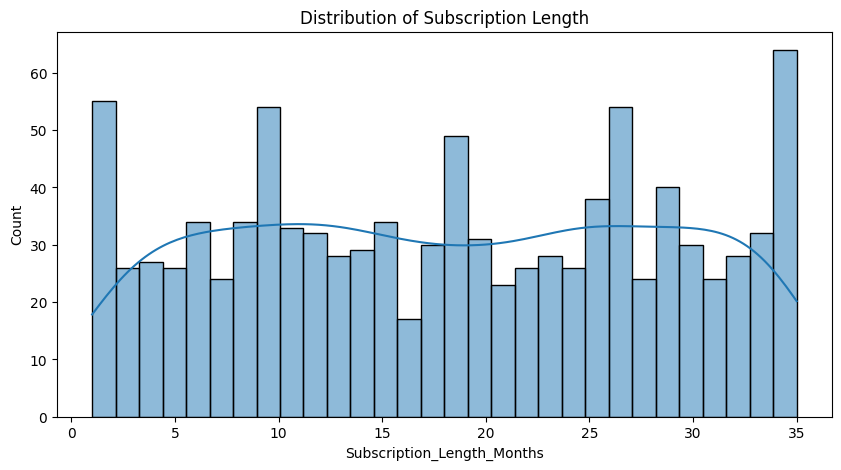

In [ ]:
# Visualizations
plt.figure(figsize=(10, 5))
sns.histplot(df['Subscription_Length_Months'], bins=30, kde=True)
plt.title('Distribution of Subscription Length')
plt.show()

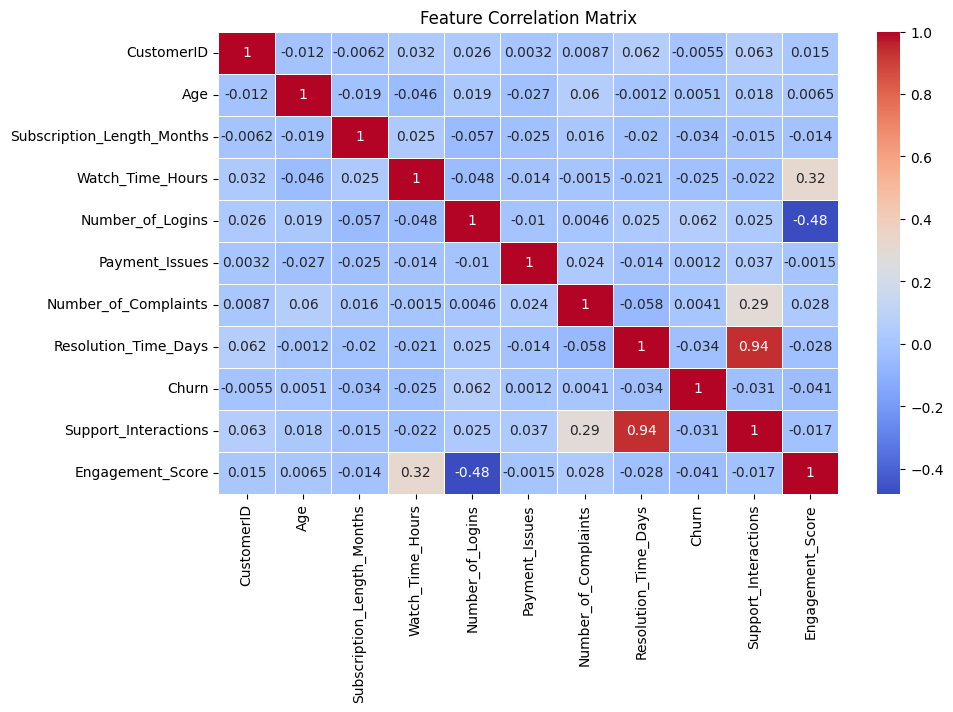

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Splitting dataset
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("Class distribution:\n", y_train.value_counts())

Class distribution:
 Churn
0    594
1    206
Name: count, dtype: int64


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addressing class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
# Train Decision Tree with Hyperparameter Tuning
dt_params = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': ['balanced']
}
gs_dt = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5, scoring='precision')
gs_dt.fit(X_train_balanced, y_train_balanced)
dt = gs_dt.best_estimator_
y_pred_dt = dt.predict(X_test_scaled)

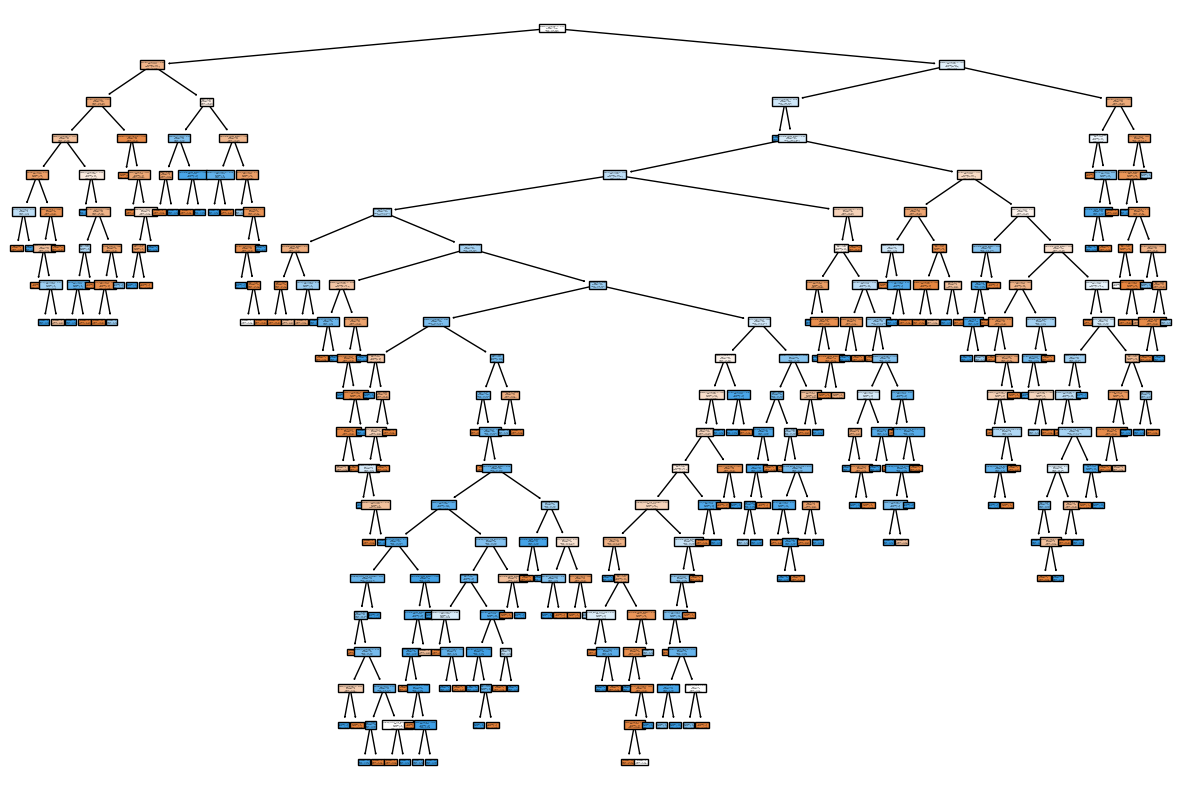

In [ ]:
# Visualizing Decision Tree
plt.figure(figsize=(15, 10))
plot_tree(dt, feature_names=X.columns, class_names=['No Churn', 'Churn'], filled=True)
plt.show()

In [ ]:
# Train Random Forest with Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}
gs_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='precision')
gs_rf.fit(X_train_balanced, y_train_balanced)
rf = gs_rf.best_estimator_
y_pred_rf = rf.predict(X_test_scaled)

In [ ]:
# Model Evaluations
def evaluate_model(name, y_true, y_pred):
    print(f"{name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=1))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)

Decision Tree Performance:
Accuracy: 0.58
Precision: 0.2549019607843137
Recall: 0.22033898305084745
F1 Score: 0.23636363636363636
Confusion Matrix:
 [[103  38]
 [ 46  13]]
Random Forest Performance:
Accuracy: 0.625
Precision: 0.2777777777777778
Recall: 0.1694915254237288
F1 Score: 0.21052631578947367
Confusion Matrix:
 [[115  26]
 [ 49  10]]


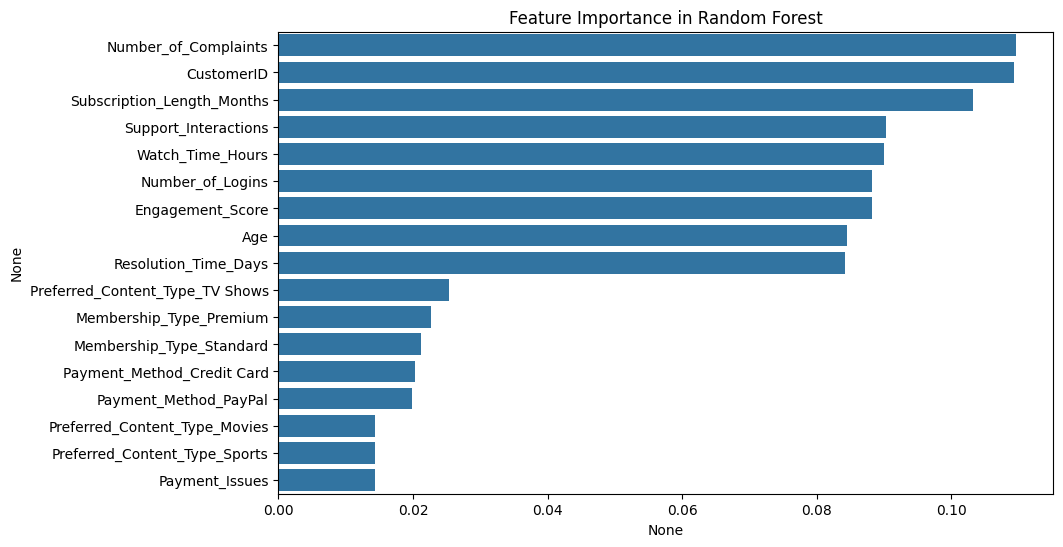

In [ ]:
# Feature Importance from Random Forest
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance in Random Forest')
plt.show()

In [ ]:
# Business Insights
print("Top Factors Contributing to Churn:")
print(feature_importance.head(5))

Top Factors Contributing to Churn:
Number_of_Complaints          0.109676
CustomerID                    0.109292
Subscription_Length_Months    0.103250
Support_Interactions          0.090335
Watch_Time_Hours              0.090026
dtype: float64


#Recommended Strategies:
1. Offer incentives to customers with high churn risk.
2. Improve customer support for those with frequent complaints.
3. Enhance subscription plans based on user preferences.